# Проект: Выявление потенциальных коров для покупки с помощью моделей МО для молочного хозяйства «Вольный луг»

**Цель работы:** создать модель для определения потенциальных коров для покупки молочным хозяйством

**Задачи работы:**
- Загрузить предоставленные данные по коровам
- Выполнить предобработку данных
- Проанализировать данные
- Выявить взаимосвязь между данными
- Обучить модель линейной регрессии для предсказания удоя коров
- Обучить модель логической регрессии для предсказания вкуса молока коров
- Сделать выводы

<font size='4'>
    <b>Загрузка бибилиотек</b>
</font>

In [1]:
%pip install phik -q
%pip install seaborn==0.13.2 -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


<font size='4'>
    <b>Библиотеки для анализа данных</b>
</font>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from importlib import reload
import numpy as np
from scipy import stats as st

<font size='4'>
    <b>Библиотеки для МО</b>
</font>

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, recall_score, precision_score, confusion_matrix

<font size='4'>
    <b>Константы</b>
</font>

In [4]:
RANDOM_STATE = 42

## Загрузка данных

### Данные о коровах хозяйства (файл "ferma_main.csv")

Загрузим данные первого csv файла (данные разделены знаком ";").

In [5]:
try:
    # Считываем данные
    ferma_raw_data = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', sep=';', decimal = ',')
    # Выводим пять случайных строк для проверки корректности чтения
    print('Даннные были загружены успешно!\n\nПять случайных строк фрейма:')
    display(ferma_raw_data.sample(n=5, random_state=RANDOM_STATE))
    # Выведем размер фрейма
    print(f'\nФрейм состоит из {ferma_raw_data.shape[1]} признаков и {ferma_raw_data.shape[0]} объектов')

    # Выводим общую информацию о фрейме
    print('\nОбщая информация о фрейме:')
    ferma_raw_data.info()
except:
    print('Ошибка загрузки данных! Проверь корректность пути к файлу.')

Даннные были загружены успешно!

Пять случайных строк фрейма:


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
396,397,6015,15.0,1739,0.93,РефлешнСоверинг,Холмистое,Соверин,3.72,3.077,не вкусно,более_2_лет
248,249,6716,16.3,2258,0.94,Вис Бик Айдиал,Равнинное,Айдиал,3.73,3.079,не вкусно,более_2_лет
215,216,5795,12.7,1687,0.86,Вис Бик Айдиал,Холмистое,Айдиал,3.42,3.076,не вкусно,более_2_лет
353,354,6455,14.8,1835,0.93,РефлешнСоверинг,Равнинное,Соверин,3.71,3.072,не вкусно,более_2_лет
548,549,6688,14.8,1727,0.93,Вис Бик Айдиал,Холмистое,Айдиал,3.72,3.074,не вкусно,более_2_лет



Фрейм состоит из 12 признаков и 634 объектов

Общая информация о фрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  

__Заменим наименования столбцов:__<br>

In [6]:
new_ferma_columns = {
                     'Удой, кг':                              'yield_kg',
                     'ЭКЕ (Энергетическая кормовая единица)': 'efd',
                     'Сырой протеин, г':                      'crude_protein_g',
                     'СПО (Сахаро-протеиновое соотношение)':  'spr',
                     'Порода':                                'breed',
                     'Тип пастбища':                          'pasture_type',
                     'порода папы_быка':                      'dads_breed',
                     'Жирность,%':                            'fat_prec', 
                     'Белок,%':                               'protein_prec',
                     'Вкус молока':                           'taste',
                     'Возраст':                               'age'
                    }

ferma_raw_data = ferma_raw_data.rename(columns=new_ferma_columns)

# Проверка
ferma_raw_data.columns

Index(['id', 'yield_kg', 'efd', 'crude_protein_g', 'spr', 'breed',
       'pasture_type', 'dads_breed', 'fat_prec', 'protein_prec', 'taste',
       'age'],
      dtype='object')

Таким образом, мы имеем 634 объектов в фрейме. Пропусков в колонках нет, типы данных соответствуют

Проведем аналогичную загрузку следущего файла.

### Данные об именах пап коров (файл "ferma_dad.csv") 

In [7]:
try:
    # Считываем данные
    dad_raw_data = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', sep=';')
    # Выводим пять случайных строк для проверки корректности чтения
    print('Даннные были загружены успешно!\n\nПять случайных строк фрейма:')
    display(dad_raw_data.sample(n=5, random_state=RANDOM_STATE))
    # Выведем размер фрейма
    print(f'\nФрейм состоит из {dad_raw_data.shape[1]} признаков и {ferma_raw_data.shape[0]} объектов')

    # Выводим общую информацию о фрейме
    print('\nОбщая информация о фрейме:')
    dad_raw_data.info()
except:
    print('Ошибка загрузки данных! Проверь корректность пути к файлу.')

Даннные были загружены успешно!

Пять случайных строк фрейма:


,id,Имя Папы
494,495,Барин
244,245,Барин
551,552,Барин
213,214,Барин
532,533,Соловчик



Фрейм состоит из 2 признаков и 634 объектов

Общая информация о фрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Проведем аналогичные с первым фреймом изменения

In [8]:
# Переименование признаков
new_dad_columns = {'Имя Папы': 'dads_name'}
dad_raw_data = dad_raw_data.rename(columns = new_dad_columns)
# Проверка
dad_raw_data.columns

Index(['id', 'dads_name'], dtype='object')

<a id='dupl-cell'></a>Фрейм состоит из 629 объектов, что меньше чем в предыдущем фрейме. Значит, есть вероятность недостаточности данных (не для всех коров указаны имена отцов) или в первом фрейме присутствуют дубликаты.

Проведем аналогичную загрузку последнего фрейма

### Данные о потенциально покупаемых коровах (файл "cow_buy.csv") 

In [9]:
try:
    # Считываем данные
    buy_raw_data = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', sep=';', decimal = ',')
    # Выводим пять случайных строк для проверки корректности чтения
    print('Даннные были загружены успешно!\n\nПять случайных строк фрейма:')
    display(buy_raw_data.sample(n=5, random_state=RANDOM_STATE))
    # Выведем размер фрейма
    print(f'\nФрейм состоит из {buy_raw_data.shape[1]} признаков и {buy_raw_data.shape[0]} объектов')

    # Выводим общую информацию о фрейме
    print('\nОбщая информация о фрейме:')
    buy_raw_data.info()
except:
    print('Ошибка загрузки данных! Проверь корректность пути к файлу.')

Даннные были загружены успешно!

Пять случайных строк фрейма:


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
17,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.77,3.053,менее_2_лет
15,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет



Фрейм состоит из 7 признаков и 20 объектов

Общая информация о фрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Заменим наименования столбцов

In [10]:
new_buy_columns = {
                     'Порода':                  'breed', 
                     'Тип пастбища':            'pasture_type',
                     'порода папы_быка':        'dads_breed',
                     'Имя_папы':                'dads_name',
                     'Текущая_жирность,%':      'fat_prec',
                     'Текущий_уровень_белок,%': 'protein_prec',
                     'Возраст':                 'age'
}

buy_raw_data = buy_raw_data.rename(columns=new_buy_columns)

# Проверка
buy_raw_data.columns

Index(['breed', 'pasture_type', 'dads_breed', 'dads_name', 'fat_prec',
       'protein_prec', 'age'],
      dtype='object')

В данном фрейме есть 20 объектов. Пустных значений нет, неверных типов также нет

**Итог:**<br>
- Данные трех фреймов были выгружены, были изменены наименования признаков.
- В фрейме данных по коровам хозяства замечены столбцы с неверным типом данных, возможны дубликаты (кол-во строк должно совпадать с кол-вом строк фрейма по данным коров хозяйства), необходимо выделить отдельные таблицы и заменить два текущих признака фрейма
- В фрейме данных по именам пап коров возможна нехватка данных (кол-во объектов должно совпадать с кол-вом объектов фрейма по данным коров хозяйства)
- В фрейме данных покупаемых коров также необходимы изменение типов признаков и замена признака на смежный

##  Предобработка данных

На данном шаге необходимо сделать следующую предобработку:<a id='changes'></a>
- Проверить дубликаты в фрейме "ferma_raw_data". При необходимости удалить
- Проверить дубликаты в фрейме "dad_raw_data". При необходимости удалить
- Проверить дубликаты в фрейме "buy_raw_data". При необходимости удалить

### Проверка дубликатов фрейма "ferma_raw_data"

Стоит отметить, что нас интересуют лишь дубликаты `id` коров (это одна и та же корова). Сразу ограничим поиск дубликатов по данному признаку

In [11]:
# Проверка на дубликаты id
ferma_raw_data['id'].duplicated().sum()

5

Таким образом в фрейме есть 5 дубликатов ([как и предполагалось на этапе загрузки фрейма "dad_raw_data"](#dupl-cell)). Исключим их из фрейма

In [12]:
ferma_filtered_data = ferma_raw_data.drop_duplicates(subset='id')
# Проверка
ferma_filtered_data['id'].duplicated().sum()

0

Проверим неявные дубликаты. Начнем с признака `Порода` (`breed`)

In [13]:
ferma_filtered_data['breed'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

Неявных дубликатов нет. Проверим неявные дубликаты в признаке `Тип пастбища` (`pasture_type`)

In [14]:
ferma_filtered_data['pasture_type'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

Заметны неявные дубликаты названий. Заменим значение "Равнинные" на "Равнинное"

In [15]:
# Замена
ferma_filtered_data['pasture_type'] = ferma_filtered_data['pasture_type'].replace('Равнинные', 'Равнинное')
# Проверка
ferma_filtered_data['pasture_type'].unique()

C:\Users\Александр\AppData\Local\Temp\ipykernel_5516\4131141900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ferma_filtered_data['pasture_type'] = ferma_filtered_data['pasture_type'].replace('Равнинные', 'Равнинное')


array(['Равнинное', 'Холмистое'], dtype=object)

Аналогично проверим признак `Порода папы` (`dads_breed`)

In [16]:
ferma_filtered_data['dads_breed'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

Заменим значение "Айдиалл" на "Айдиал"

In [17]:
# Замена
ferma_filtered_data['dads_breed'] = ferma_filtered_data['dads_breed'].replace('Айдиалл', 'Айдиал')
# Проверка
ferma_filtered_data['dads_breed'].unique()

C:\Users\Александр\AppData\Local\Temp\ipykernel_5516\3074904205.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ferma_filtered_data['dads_breed'] = ferma_filtered_data['dads_breed'].replace('Айдиалл', 'Айдиал')


array(['Айдиал', 'Соверин'], dtype=object)

В данном фрейме неявных дубликатов больше нет

### Проверка дубликатов фрейма "dad_raw_data"

Стоит отметить, что нас интересуют лишь дубликаты `id` коров (это одна и та же корова). Сразу ограничим поиск дубликатов по данному столбцу

In [18]:
dad_raw_data['id'].duplicated().sum()

0

Дубликатов нет

Проверка неявных дубликатов в признаке `Имя папы` (`dads_name`)

In [19]:
dad_raw_data['dads_name'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

Неявных дубликатов нет

### Проверка дубликатов фрейма "buy_raw_data"

В данном фрейме мы будем искать полные дубликаты

In [20]:
buy_raw_data.duplicated().sum()

4

Удалим дубликаты

In [21]:
buy_filtered_data = buy_raw_data.drop_duplicates()
# Проверка
buy_filtered_data.duplicated().sum()

0

Обновим индексы, старые сохраним под названием id

In [22]:
buy_filtered_data = buy_filtered_data.reset_index().rename(columns={'index': 'id'})

Проверим неявные дубликаты. Начнем с признака `Порода` (`breed`)

In [23]:
buy_filtered_data['breed'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

Дубликатов нет. Перейдем к признаке `Тип пастбища` (`pasture_type`)

In [24]:
buy_filtered_data['pasture_type'].unique()

array(['холмистое', 'равнинное'], dtype=object)

Дубликатов нет, однако слово написано строчными буквами. Для дальнейшей работы стоит привести значения аналогичного признака в фрейме коров хозяйства к нижнему регистру

In [25]:
# Приведение к нижнему регистру
ferma_filtered_data['pasture_type'] = ferma_filtered_data['pasture_type'].str.lower()\
# Проверка
ferma_filtered_data['pasture_type'].unique()

C:\Users\Александр\AppData\Local\Temp\ipykernel_5516\2956028819.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ferma_filtered_data['pasture_type'] = ferma_filtered_data['pasture_type'].str.lower()\


array(['равнинное', 'холмистое'], dtype=object)

Готово. Теперь проверим неявные дубликаты в следующем признаке `Порода папы` (`dads_breed`)

In [26]:
buy_filtered_data['dads_breed'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

Дубликатов нет. Последний признак `Имя папы` (`dads_name`)

In [27]:
buy_filtered_data['dads_name'].unique()

array(['Геркулес', 'Буйный', 'Барин', 'Соловчик'], dtype=object)

Неявных дубликатов в фрейме нет

**Итог:**<br>
Все [вышеперечисленные изменения](#changes) были успешно произведены

## Исследовательский анализ данных

Мы проведем исследовательский анализ данных фрейма данных о коровах хозяйства. Изучим данные всех признаков фрейма за исключением признака "id".<br>
- Для **количественных** данных мы оценим разброс данных по гистограмме и описанию данных
- Для **качественных** данных мы построим столбчатые графики для выявления тенденций<a id='quan_cell'></a>

Заранее создадим функции для описания данных

In [28]:
# Функция для получения старого названия признака, нужна для повышения читаемости графиков
def get_old_column_name(current_col_name):
    return list(new_ferma_columns.keys())[list(new_ferma_columns.values()).index(current_col_name)]

In [29]:
def describe_quan_col(col_key):
    # Берем необходимую колонку
    column = ferma_filtered_data[col_key]
    
    # Общее описание количественных данных
    display(column.describe())
    
    # Получаю старое наименование колонки для читаемости графиков
    col_name = get_old_column_name(col_key)
    
    # Создаем гистограмму
    column.plot(kind='hist',
                bins=50,
                figsize=(12, 6),
                label=col_name,
                title=f'Гистограмма значений "{col_name}"'
             )
    
    # Вертикальная линия медианы
    plt.axvline(column.median(),
                color='red',
                linestyle='--',
                label=f'Медиана значений колонки "{col_name}"')
    
    # Вертикальная линия среднего значения
    plt.axvline(column.mean(),
                color='red',
                linestyle='-',
                label=f'Среднее значение колонки "{col_name}"')
    # Переименуем оси
    plt.ylabel('Количество коров')
    plt.xlabel(col_name)
    # Легенда для читаемости
    plt.legend()
    # Вывод графика
    plt.show()

count      629.000000
mean      6188.750397
std       1644.795489
min       5204.000000
25%       5751.000000
50%       6133.000000
75%       6501.000000
max      45616.000000
Name: yield_kg, dtype: float64

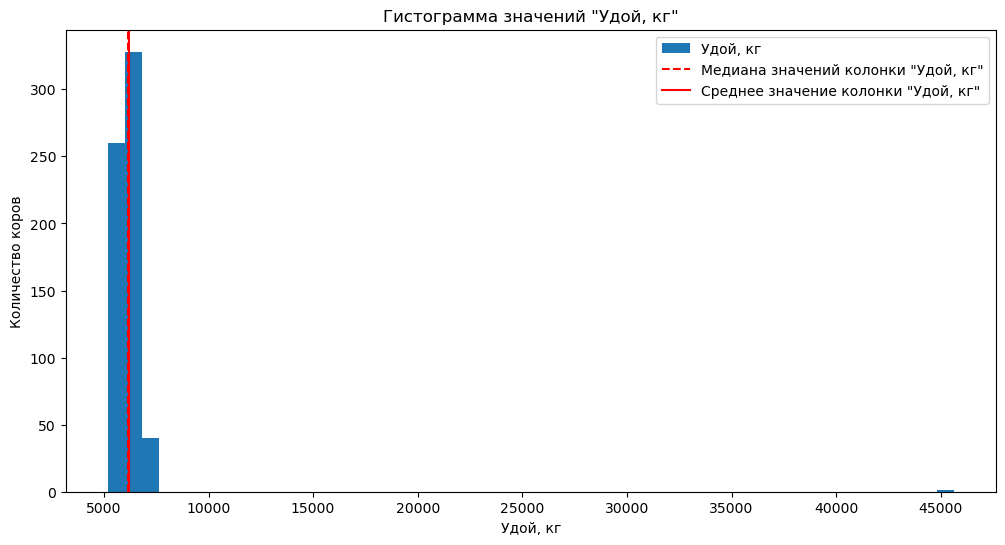

In [30]:
# Удой, кг
describe_quan_col('yield_kg')

По графику и таблице виден выброс данных - удой одной коровы составил 45 тысяч кг.<br>Есть предположение, что произошла техническая ошибка и, на самом деле, значение в 10 раз меньше. Однако и при подтверждении предположения данное значение будет являться выбросом.<br>**В связи с этим следует убрать данное значение из выборки и провести повторный анализ**

count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: yield_kg, dtype: float64

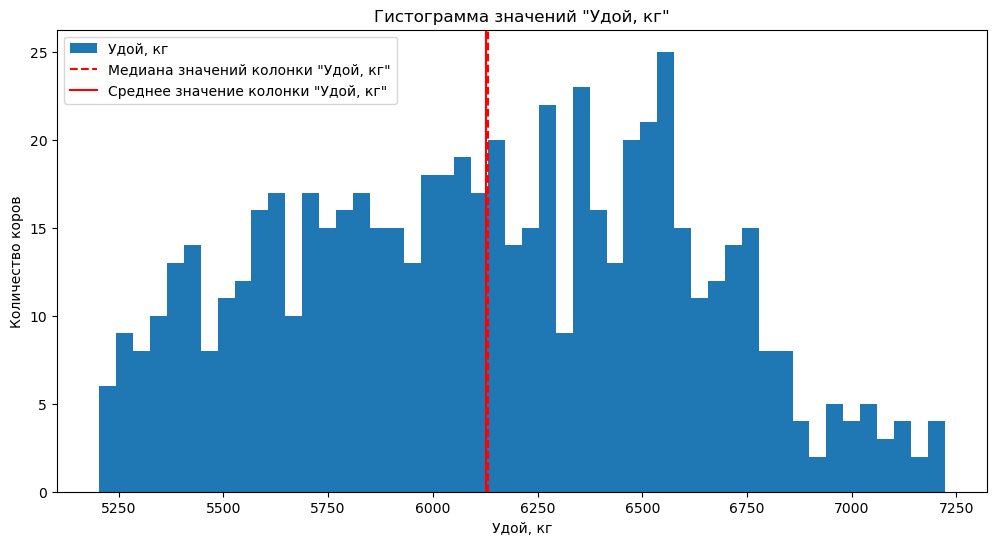

In [31]:
# Удаляем выброс
ferma_filtered_data = ferma_filtered_data.query('yield_kg < 10000')
# Повторный анализ
describe_quan_col('yield_kg')

Медиана и среднее значение выборки близки, на графике выбросов нет

Перейдем к следующей колонке

count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: efd, dtype: float64

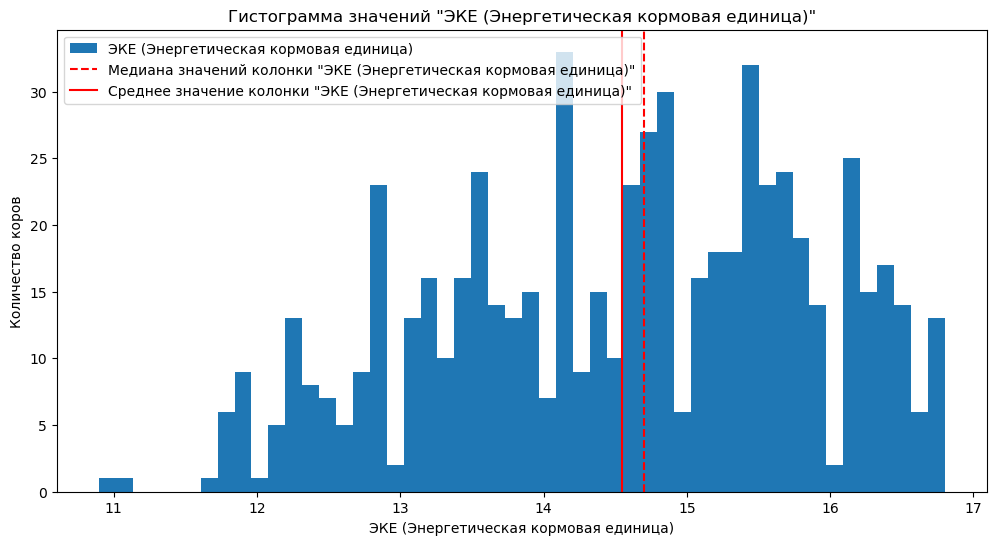

In [32]:
describe_quan_col('efd')

Также виден небольшой выброс - минимальное значение. Уберем из выборки, так как повлияет на качество модели

В остальном же распределение напоминает нормальное

count     627.000000
mean     1923.709729
std       182.974523
min      1660.000000
25%      1771.500000
50%      1888.000000
75%      2062.500000
max      2349.000000
Name: crude_protein_g, dtype: float64

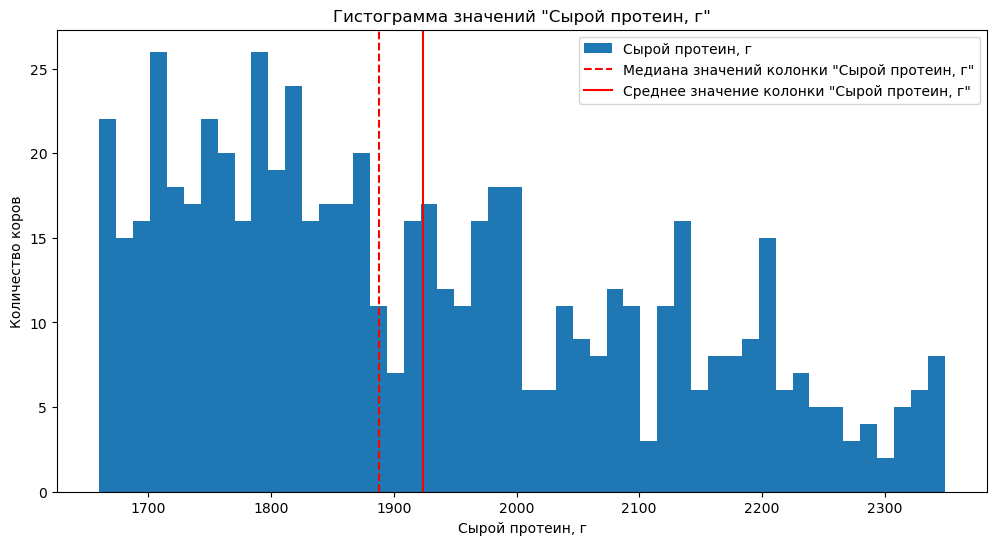

In [33]:
ferma_filtered_data = ferma_filtered_data.query('efd > 11')
describe_quan_col('crude_protein_g')

По графику видно, что распределение смещено влево - имеет отрицательную ассиметрию

count    627.000000
mean       0.913206
std        0.032114
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: spr, dtype: float64

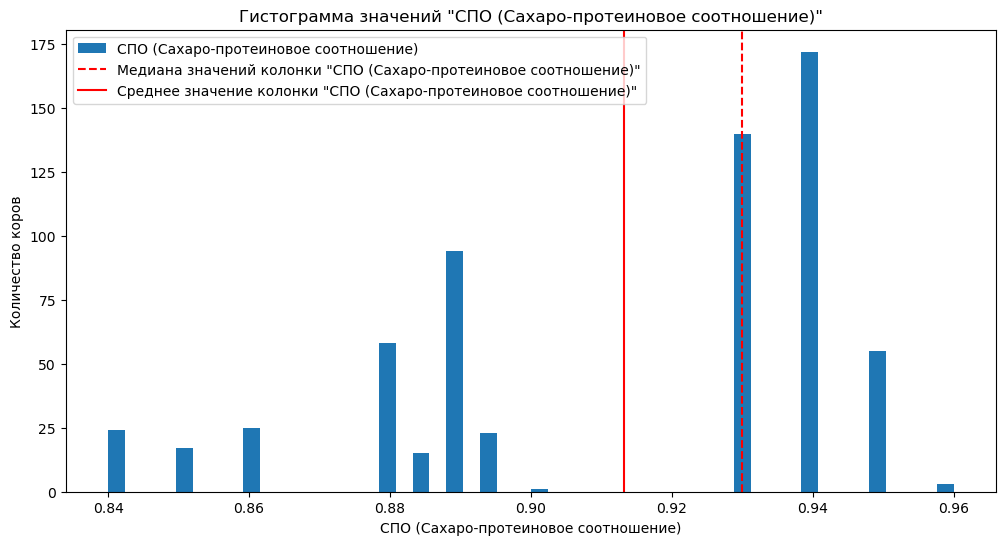

In [34]:
describe_quan_col('spr')

<a id='spo_cell'></a>Ассиметрия же этих значений является положительной (смещение графика вправо)

count    627.000000
mean       3.604609
std        0.168008
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: fat_prec, dtype: float64

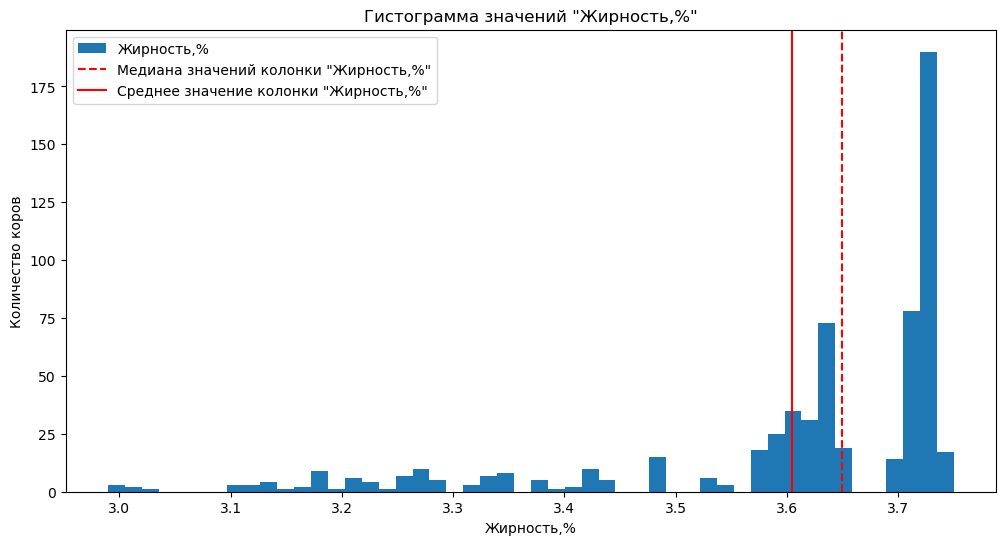

In [35]:
describe_quan_col('fat_prec')

[Аналогично значениям "СПО"](#spo_cell)

count    627.000000
mean       3.075665
std        0.002550
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: protein_prec, dtype: float64

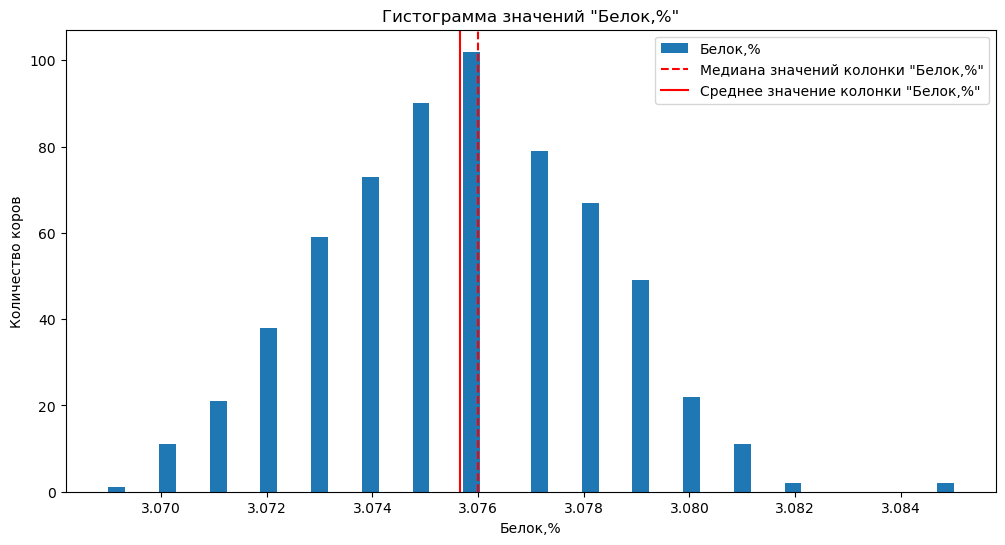

In [36]:
describe_quan_col('protein_prec')

Есть выброс - максимальное значение. В остальном график похож на нормальное распределение

count    625.000000
mean       3.075635
std        0.002498
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.082000
Name: protein_prec, dtype: float64

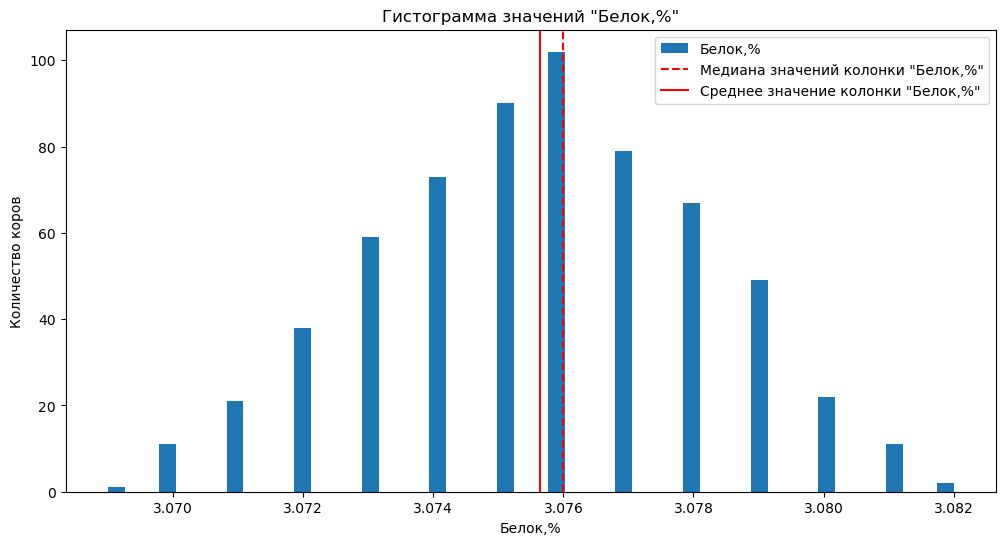

In [37]:
ferma_filtered_data = ferma_filtered_data.query('protein_prec < 3.084')
describe_quan_col('protein_prec')

[Теперь перейдем к изучению качественных данных.](#quan_cell)

In [38]:
def describe_qual_col(col_key):
    # Получаем значение колонки
    column = ferma_filtered_data[col_key]
    
    # Получаем старое название для читаемости графика
    col_name = get_old_column_name(col_key)
    
    # Создаем таблицу количества значений
    sorted_values_table = column.value_counts()
    
    # Выводим таблицу на экран
    display(sorted_values_table)
    
    # Стоим столбчатый график
    sorted_values_table.plot(
        kind='bar',
        title=f'График распределения значений "{col_name}"',
        xlabel=col_name,
        ylabel='Кол-во коров',
        figsize=(12, 6)
    )

breed
Вис Бик Айдиал     369
РефлешнСоверинг    256
Name: count, dtype: int64

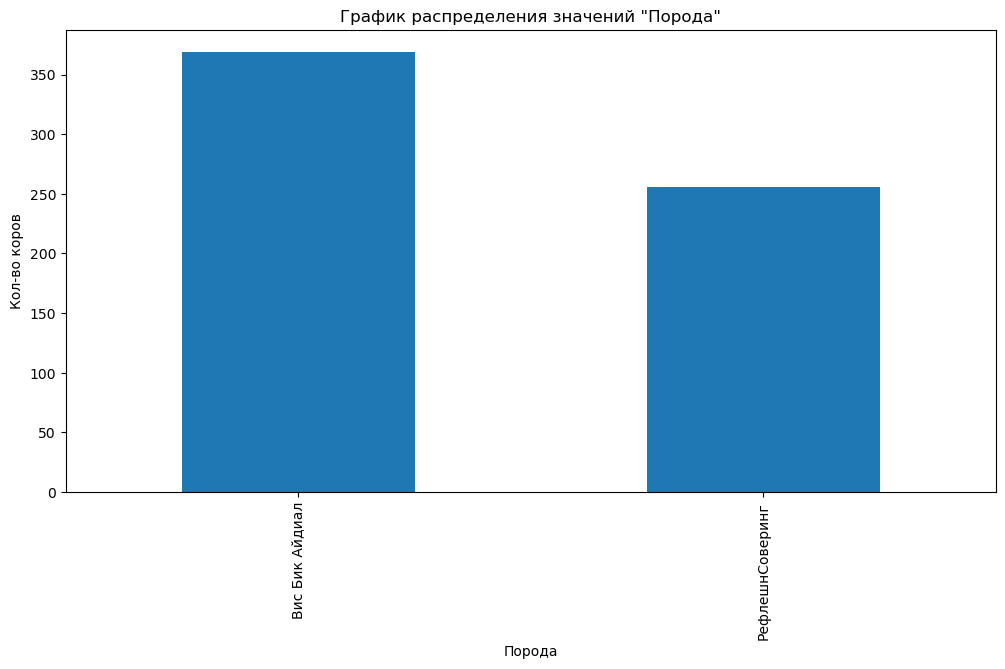

In [39]:
# Порода
describe_qual_col('breed')

Выходит, что в нашей выборке лишь две породы. Причем больше половины относятся к породе "Вис Бик Айдиал".

Стоит отметить, что порода коровы - совмещенная порода папы и мамы коровы, поэтому, _возможно_, порода коровы не будет актуальна для модели, в отличие от породы папы коровы

pasture_type
холмистое    348
равнинное    277
Name: count, dtype: int64

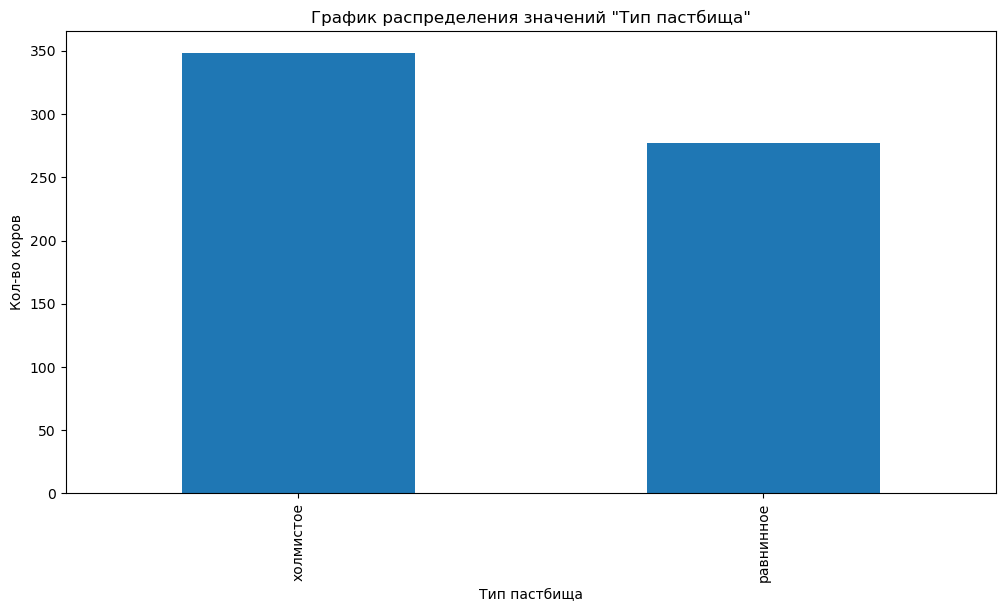

In [40]:
# Тип пастбища
describe_qual_col('pasture_type')

В выборке преобладаеют данные с типом пастбища - Холмистое (больше половины коров пасутся на таких пастбищах)

dads_breed
Айдиал     316
Соверин    309
Name: count, dtype: int64

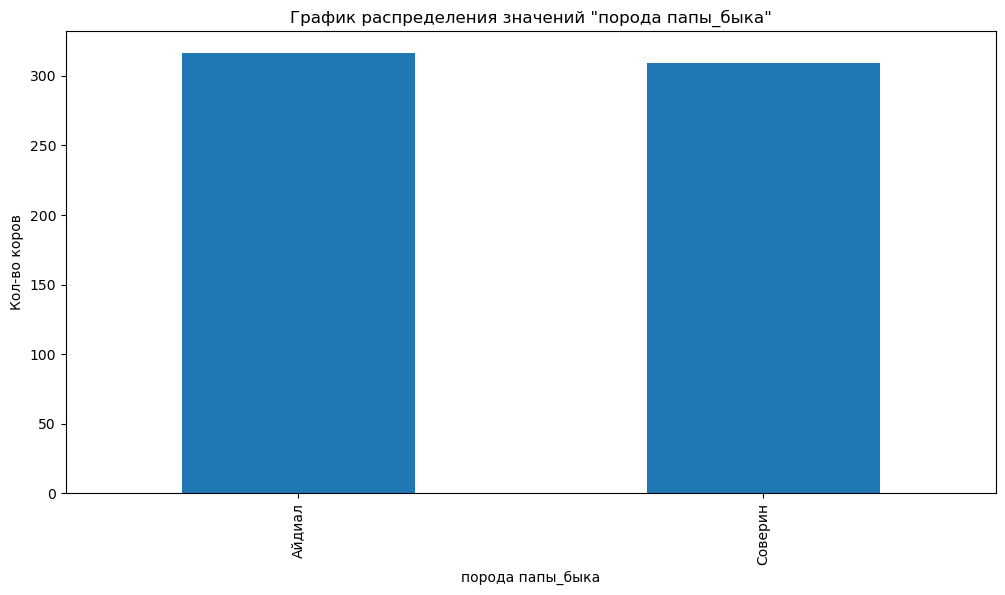

In [41]:
# Порода папы
describe_qual_col('dads_breed')

По распределению пород пап коров видно, что почти равные доли у пород пап

taste
вкусно       367
не вкусно    258
Name: count, dtype: int64

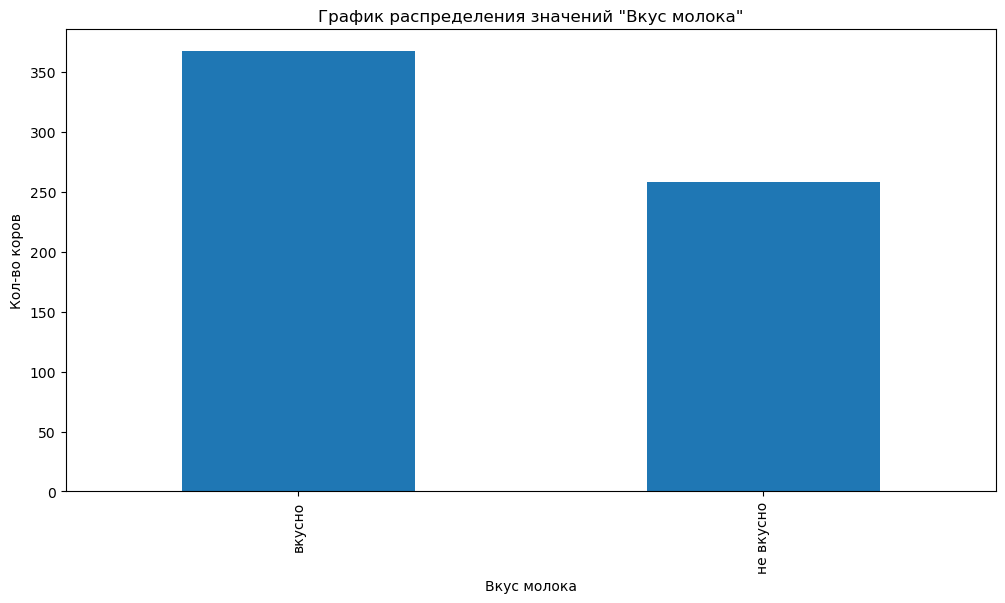

In [42]:
# Вкус
describe_qual_col('taste')

Больше половины коров хозяйства дают вкусное молоко, однако есть коровы с невкусным молоком

age
более_2_лет    516
менее_2_лет    109
Name: count, dtype: int64

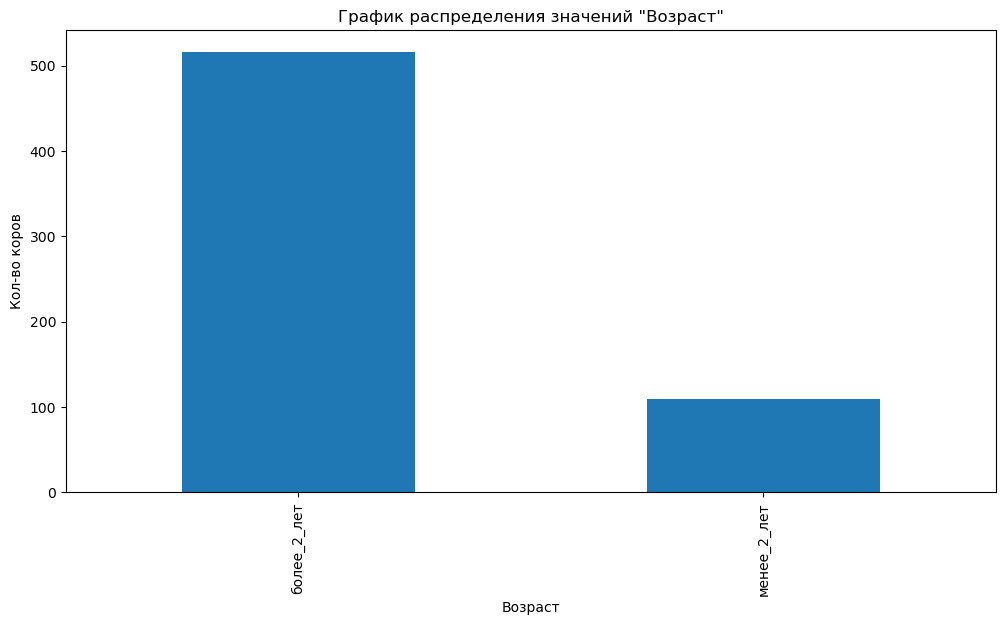

In [43]:
# Возраст
describe_qual_col('age')

Большая часть коров в возрасте более двух лет. 109 коров с возрастом менее 2 лет

**Итог:**
- Были проанализированы количественные данные, выведены графики и изучины статистические распределения и метрики. Из выборки были исключены выбросы
- Были построены графики для количественных данных

**Статистическая корова хозяйства:**
- Удой составляет 6125 кг
- Содержание сырого протеина составляет 1923 г
- СПО - 0,91
- Жирность молока - 3,6%
- Содержание белка в молоке - 3,07 %
- Относится к породе Вис Бик Айдиал
- Дает вкусное молоко
- Возраст составляет более двух лет

Про породу папы сказать точно нельзя, так как доли двух пород относительно равны

## Корреляционный анализ

Рассчитаем коэффициенты корреляции между признаками фрейма "ferma_filtered_data". Перед этим переведем столбец id в индекс фрейма

In [44]:
# Делаем индексом
ferma_filtered_data = ferma_filtered_data.set_index('id')
# Проверка
ferma_filtered_data.head()

,yield_kg,efd,crude_protein_g,spr,breed,pasture_type,dads_breed,fat_prec,protein_prec,taste,age
id,,,,,,,,,,,
1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


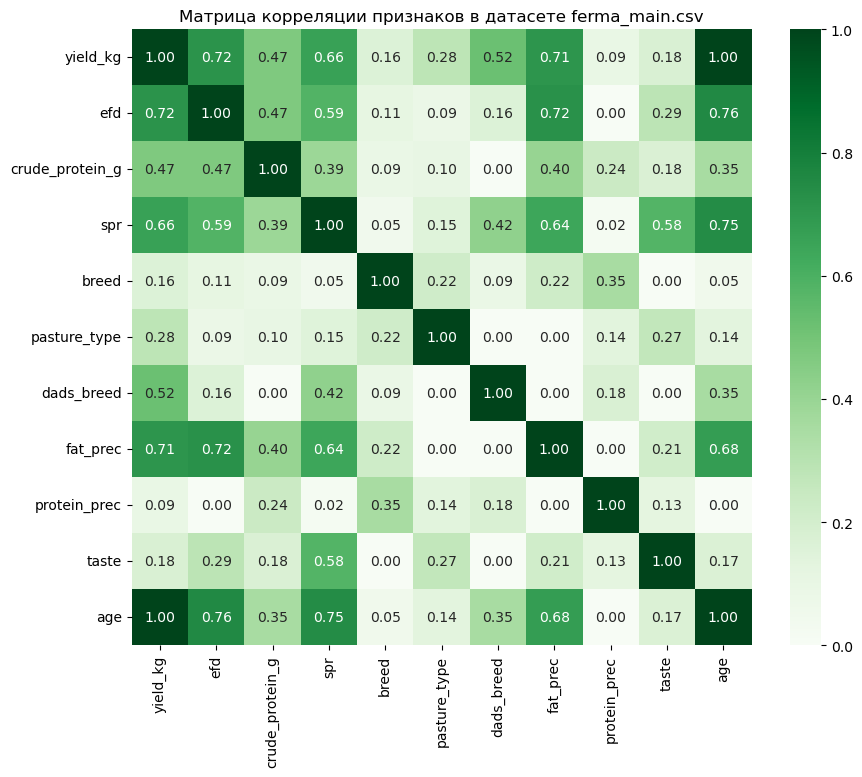

In [45]:
ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ferma_filtered_data.phik_matrix(interval_cols=['yield_kg', 'efd', 'crude_protein_g', 'spr', 'fat_prec', 'protein_prec']), 
            annot=True,
            cmap="Greens",
            fmt='.2f')

plt.title('Матрица корреляции признаков в датасете ferma_main.csv')
plt.show()

По графику видно, что наибольшую корреляцию с целевым признаком "Удой, кг" имеют следующие признаки (расположены по мере уменьшения коэффициента корреляции):
- Возраст
- ЭКЕ (Энергетическая кормовая единица)
- Жирность,%
- СПО (Сахаро-протеиновое соотношение)

Стоит также отметить высокую корреляцию между признаками "ЭКЕ (Энергетическая кормовая единица)", "СПО (Сахаро-протеиновое соотношение)" и "Жирность,%". Для создания модели стоит удалить признаки "СПО (Сахаро-протеиновое соотношение)" и "Жирность,%".

Построим диаграммы рассеяния для признака "Удой, кг" и всех количественных признаков с учётом значения категориальных признаков. Предварительно сделаем два технический списка.

In [46]:
# Количественные признаки
quan_cols = ['efd', 'crude_protein_g', 'spr', 'fat_prec', 'protein_prec']
# Качественные признаки
qual_cols = ['breed', 'pasture_type', 'dads_breed', 'taste', 'age']

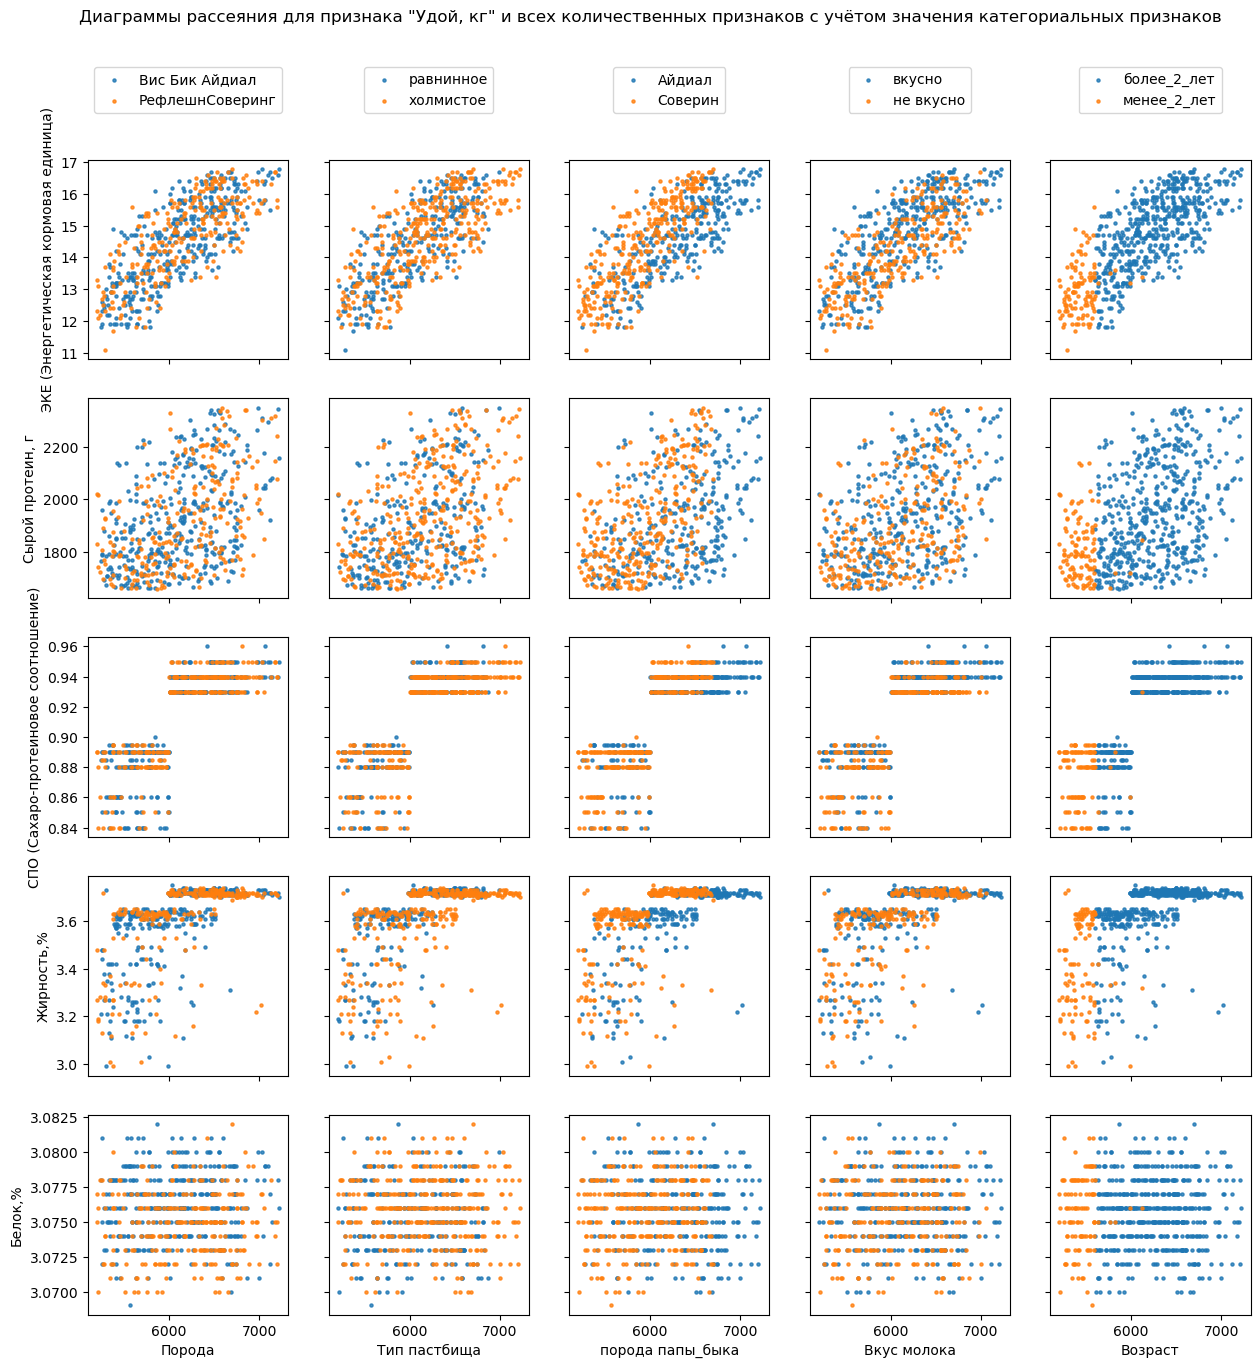

In [47]:
# Создаем матрицу графиков, размер больше для читабельности
fig, axs = plt.subplots(len(quan_cols),
                        len(qual_cols),
                        figsize=(15, 15))

# Циклом проходим по качественным признакам
for i in range(len(quan_cols)):
    # Получаем ключ кач. признака
    quan_col = quan_cols[i]
    # Получаем старое название для читабельности графика
    quan_col_name = get_old_column_name(quan_col)
    # Выбираем количественные признаки
    for j in range(len(qual_cols)):
        # Получаем ключ кол. признака
        qual_col = qual_cols[j]
        # Получаем старое название для читабельности графика
        qual_col_name = get_old_column_name(qual_col)
        # Группируем данные по качественному признаку
        for qual_col_type, qual_col_data in ferma_filtered_data.groupby(qual_col):
            # Создаем диаграмму рассеяния между признаком "Удой, кг" и кол. признаком на данном шаге
            axs[i, j].scatter(x=qual_col_data['yield_kg'],
                              y=qual_col_data[quan_col],
                              alpha=0.8,
                              label=qual_col_type,
                              s=5)
            # Ставим наименование кол. признака
            axs[i, j].set_xlabel(qual_col_name)
            # Ставим наименование кач. признака
            axs[i, j].set_ylabel(quan_col_name)
            # Создаем легенду лишь для первой строки и ставим ее над графиками для читаемости
            if i == 0 :
                axs[i, j].legend(loc='upper center', bbox_to_anchor=(0.5,1.5))
            # Убираем наименования осей в края графика
            axs[i, j].label_outer()
            
# Называем график
fig.suptitle('Диаграммы рассеяния для признака "Удой, кг" и всех количественных признаков с учётом значения категориальных признаков')
# Выводим график
plt.show()

По данной диаграмме подтверждается, что признак "Удой, кг" коррелирует с признаком "ЭКЕ (Энергетическая кормовая единица)" (точки графика находятся близко к общей оси). Также хорошо видно, что есть взаимосвязь между признаком "Удой, кг" и "Возраст" - все коровы менее 2 лет дают не более ~5,5 тысяч кг удоя.

**Итог:**
- Целевой признак "Удой, кг" имеет наибольшую корреляцию с признаками "Возраст", "ЭКЕ (Энергетическая кормовая единица)", "Жирность,%", "СПО (Сахаро-протеиновое соотношение)"
- Наблюдается мультиколлериальность  между признаками "ЭКЕ (Энергетическая кормовая единица)", "СПО (Сахаро-протеиновое соотношение)" и "Жирность,%". Для создания модели стоит удалить признаки "СПО (Сахаро-протеиновое соотношение)" и "Жирность,%".
- Нелинейная корреляция заметна между целевым признаком и признаками "СПО (Сахаро-протеиновое соотношение)", "СПО (Сахаро-протеиновое соотношение)"
- По графику наблюдается корреляция между породой папы и целевым признаком (порода Айдиал обладает большим удоем, по сравнению с породой Соверин)

## Обучение модели линейной регрессии

Создадим первую модель для прогнозирования признака "Удой, кг" покупаемых коров.
- **Первая модель** будет построена только на признаках, подходящих для линейной модели
- **Вторая модель** будет построена с учётом связи входных признаков с целевым
- **Третья модель** будет построена с учетом изменений данных

### Первая модель

Для данной модели мы будем использовать следующие признаки:
- ЭКЕ (Энергетическая кормовая единица) - прямая корреляция с целевым признаком
- Сырой протеин, г  - прямая корреляция с целевым признаком
- СПО (Сахаро-протеиновое соотношение) - прямая корреляция с целевым признаком
- Порода папы - видна разница значения целевого признака в разреце данной категории
- Тип пастбища
- Порода
- Возраст - видна разница значения целевого признака в разреце данной категории

Напишем функцию, которая будет разрабатывать и обучать модель линейной регрессии

In [48]:
def get_model_ready(quan_columns, qual_columns, dataframe):    
    # Выделим входные и целевые признаки
    X = dataframe[quan_columns + qual_columns]
    y = dataframe['yield_kg']
    
    # Разделим выборки на тренировочные и тестовые
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE)
    
    # Кодируем качественные признаки
    encoder = OneHotEncoder(drop='first', sparse=False)
    X_train_ohe = encoder.fit_transform(X_train[qual_columns])
    X_test_ohe = encoder.transform(X_test[qual_columns])

    encoder_col_names = encoder.get_feature_names_out()
    
    # Масштабируем количественные признаки
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[quan_columns])
    X_test_scaled = scaler.transform(X_test[quan_columns])

    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=quan_columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=quan_columns)
    
    # Обновляем тренировочные и тестовые выборки
    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

    # Обучаем модель
    model_lr  = LinearRegression()
    model_lr.fit(X_train, y_train)
    
    # Получаем предсказания на тестовых данных
    predictions = model_lr.predict(X_test)
    
    # Выводим коэффициент детерминации
    print(f'Коэффициент детерминации данной модели составляет: {r2_score(y_test, predictions):.5f}')

    # Считаем остатки
    residuals = y_test - predictions
    
    # Выводим сумму остатков
    print(f'Сумма остатков данной модели составляет: {residuals.sum()}')

    # Строим графики для анализа остатков
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
    axes[0].hist(residuals)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(predictions, residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()
    
    # Для последующей работы сохраним 
    return {
        'model': model_lr,
        'scaler': scaler,
        'encoder': encoder,
        'y_true': y_test.values,
        'y_pred': predictions
    }

c:\Users\Public\New folder\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Коэффициент детерминации данной модели составляет: 0.77503
Сумма остатков данной модели составляет: -6411.572887669637


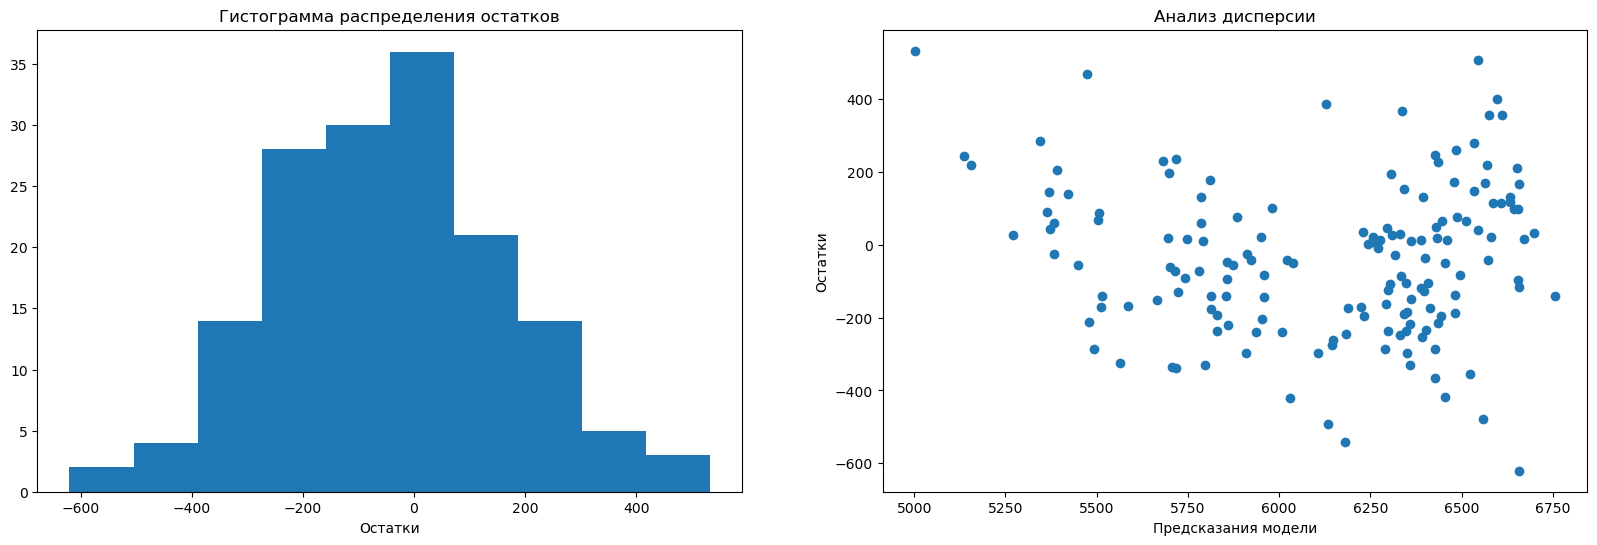

In [49]:
# Количественные данные
quan_cols = ['efd', 'crude_protein_g', 'spr']
# Качественные данные
qual_cols = ['dads_breed', 'age', 'pasture_type', 'breed']
# Результат модели
model_1 = get_model_ready(quan_cols, qual_cols, ferma_filtered_data)

**Вывод по результатам первой модели**:
- Коэффициент детерминации составил 0.78. Его значение близко к 1, что говорит о средней точности модели.
- Гистограмма распределения остатков напоминает нормальное распределение, однако сумма остатков далека от нуля.
- Остатки на диаграмме рассеяния показывают, что модель может работать неустойчиво, поскольку разброс остатков непостоянен. Такую модель использовать в работе нельзя.

**Модель нестабильна, следует изменить входные признаки модели**

### Вторая модель

По итогу первой модели было выявлено то, что модели необходимы доп признаки. Этими признаком будет "СПО (Сахарно-протеиновое отношение)". *Однако* данные признаки коррелируют с признаком "ЭКЕ (Энергетическая кормовая единица)". Поэтому их стоит преобразовать. Также стоит преобразовать значения признакак "ЭКЕ (Энергетическая кормовая единица)" - возвести в квадрат

In [50]:
# Создадим копию фрейма, чтобы не испортить его
ferma_copy_data = ferma_filtered_data.copy()

Преобразуем данные признака "ЭКЕ (Энергетическая кормовая единица)". Возведем в квадрат

In [51]:
ferma_copy_data['efd'] = ferma_copy_data['efd']**2

По диаграмме рассеяния виден определенный "крест" - "Удой, кг" более 6 тысяч наблюдается при "СПО (Сахарно-протеиновое отношение)" более 0.9. Переведем данные в булевое значение

In [52]:
ferma_copy_data['spr'] = ferma_copy_data['spr'] > 0.92

Повторим построение модели по примеру первой и проведем анализ модели

c:\Users\Public\New folder\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Коэффициент детерминации данной модели составляет: 0.81168
Сумма остатков данной модели составляет: -5709.427090542404


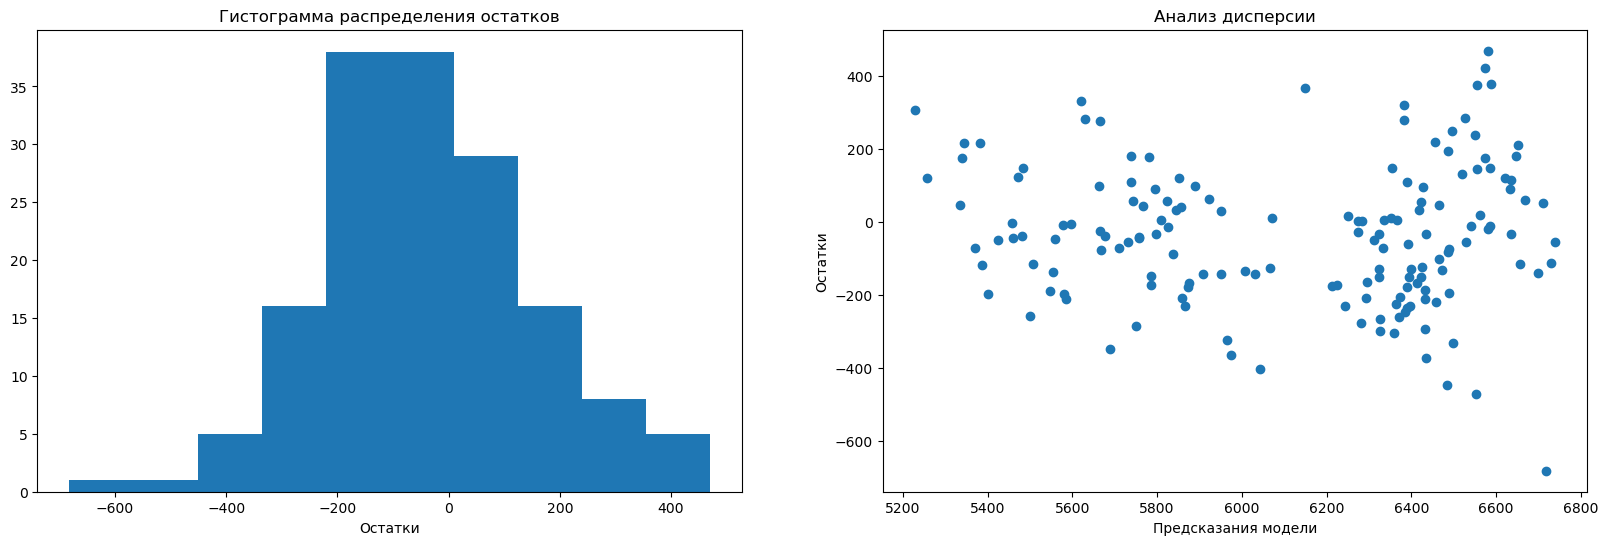

In [53]:
# Количественные данные
quan_cols = ['efd', 'crude_protein_g']
# Качественные данные
qual_cols = ['age', 'spr', 'dads_breed', 'pasture_type']
# Результат модели
model_2 = get_model_ready(quan_cols, qual_cols, ferma_copy_data)

**Вывод по результатам второй модели**:
- Коэффициент детерминации составил 0.812. Его значение ближе к 1, чем у первой модели, соответственно, данная модель более точная.
- Гистограмма распределения остатков напоминает нормальное распределение, сумма остатков также ближе к нулю.
- Остатки на диаграмме рассеяния показывают, что реже работает неустойчиво (разброс остатков стал реже). Однако наблюдается определенная дуга, что означает, что есть мультиколлениарные входные признаки

**Вторая модель дает более точные данные, по сравнению с первой. Однако есть коррелируемые признаки во входных данных**

### Третья модель

В данной модели стоит повысить точность за счет исключения мультиколлинеарности между входными данными, а также добавления нового признака "Имя папы".
Сначала добавим новый признак в исходный фрейм 

In [54]:
ferma_filtered_data = ferma_filtered_data.merge(dad_raw_data,
                                                left_on='id',
                                                right_on='id',
                                                how='left',
                                                right_index=False)
# Проверка
ferma_filtered_data.head()

,id,yield_kg,efd,crude_protein_g,spr,breed,pasture_type,dads_breed,fat_prec,protein_prec,taste,age,dads_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин


Создадим копию исходного фрейма, чтобы не испортить его. Сразу выделим признаки, необходимые для построения модели

In [55]:
ferma_copy_data = ferma_filtered_data[['yield_kg', 'efd', 'spr', 'crude_protein_g', 'pasture_type', 'age', 'breed', 'dads_breed', 'dads_name']].copy()

Повторим преобразования для признаков "ЭКЕ (Энергетическая кормовая единица)" и "СПО (Сахарно-протеиновое отношение)"

In [56]:
# Преобразование признака "ЭКЕ (Энергетическая кормовая единица)"
ferma_copy_data['efd'] = ferma_copy_data['efd']**2

# Преобразование признака "СПО (Сахарно-протеиновое отношение)"
ferma_copy_data['spr'] = ferma_copy_data['spr'] > 0.92

Теперь стоит проверить, присутствуют ли коррелируемые данные во входных данных. Построим матрицу корреляции для признаков

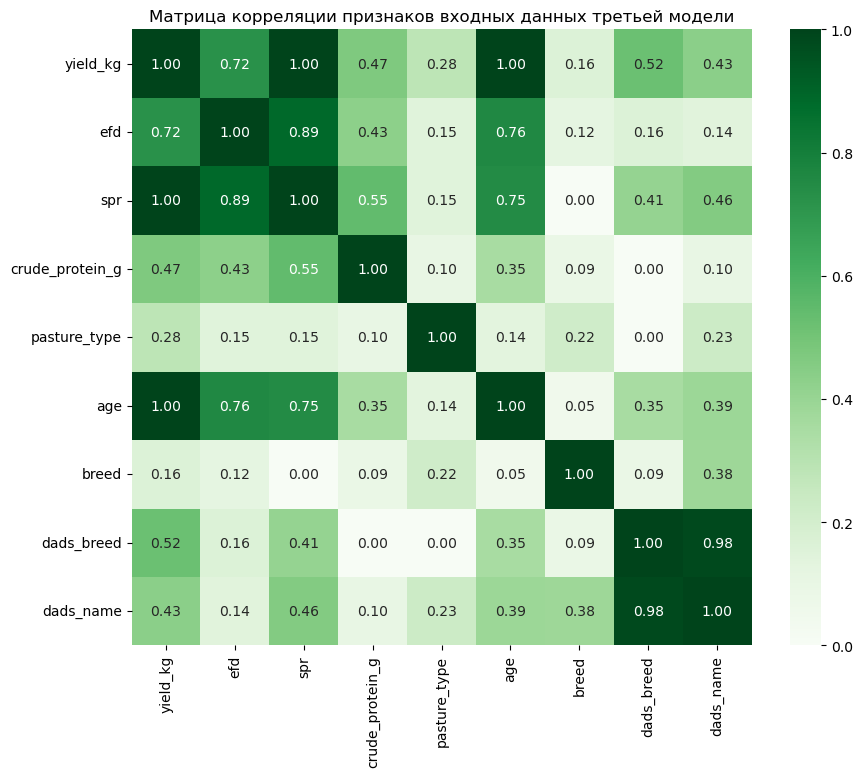

In [57]:
ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ferma_copy_data.phik_matrix(['yield_kg', 'efd', 'crude_protein_g']), 
            annot=True,
            cmap="Greens",
            fmt='.2f')

plt.title('Матрица корреляции признаков входных данных третьей модели')
plt.show()

Таким образом, мы видим, что признаки "Имя папы" и "Порода папы" - взаимозаменяемы. Удалим из выборки признак "Порода папы" (по сравнению с результатами модели, где использовался признак "Имя папы", модель с данным признаком дает более точные результаты)

In [58]:
ferma_copy_data = ferma_copy_data.drop('dads_breed', axis=1)

Теперь построим и проанализируем модель

c:\Users\Public\New folder\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Коэффициент детерминации данной модели составляет: 0.81579
Сумма остатков данной модели составляет: -4370.129027420512


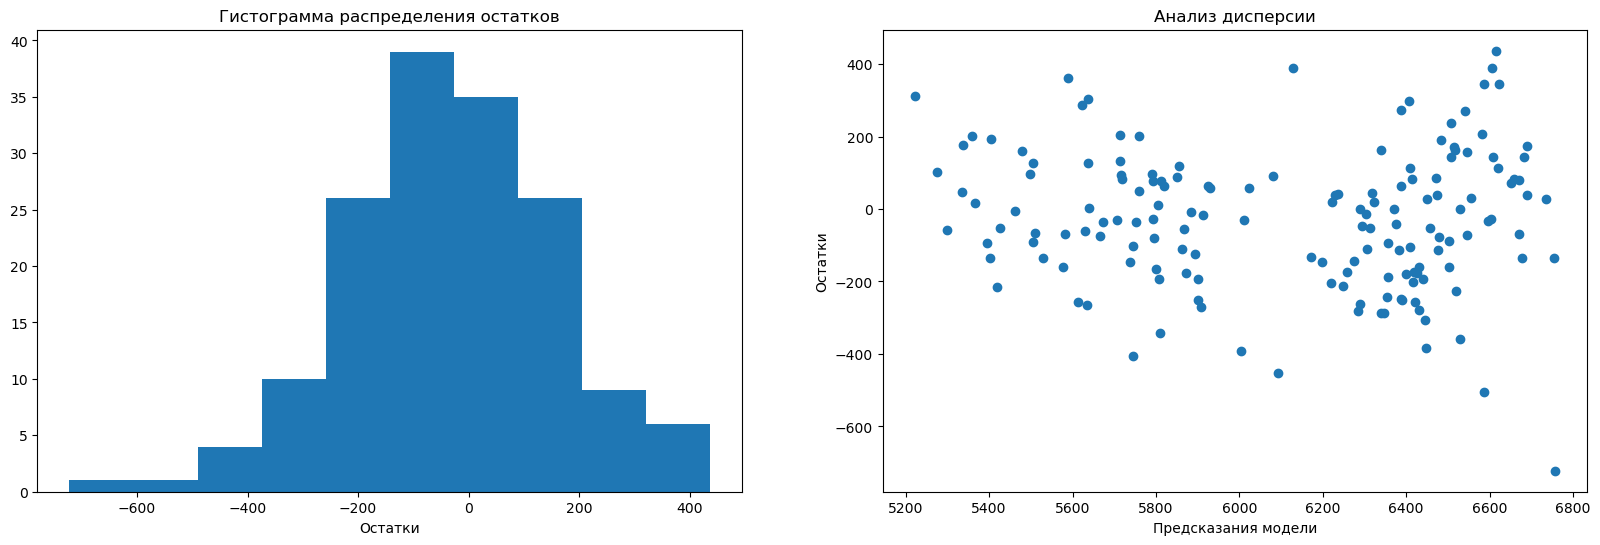

In [59]:
# Количественные данные
quan_cols = ['efd', 'crude_protein_g']
# Качественные данные
qual_cols = ['dads_name','age', 'spr', 'pasture_type']
# Результат модели
model_3 = get_model_ready(quan_cols, qual_cols, ferma_copy_data)

**Вывод по результатам третьей модели**:
- Коэффициент детерминации составил 0.816. Его значение еще ближе к 1, чем у второй модели
- Гистограмма распределения остатков напоминает нормальное распределение, сумма остатков также еще ближе к нулю.
- На диаграмме рассеяния видно, что во входных данных все так же присутствует коррелируемые признаки, однако разброс предсказаний уменьшился

**Третья модель дает наиболее точные данные из трех. Однако есть коррелируемые признаки во входных данных**

### Анализ трех моделей<a id='metrics'></a>

Выведем таблицу метрик каждой модели для сравнительного анализа. Будем сравнивать MSE, MAE, RMSE, R² и сумму остатков

In [60]:
# Итоговый массив метрик
results = []
# Сделаем цикл для итерации одних и тех же процессов
for model in [model_1, model_2, model_3]:
    # В данный массив будем заносить метрики конкретной модели на шаге цикла
    model_results = []
    # y_true
    y_true = model['y_true']
    # y_pred
    y_pred = model['y_pred']
    # MSE
    model_results.append(mean_squared_error(y_true, y_pred))
    # MAE
    model_results.append(mean_absolute_error(y_true, y_pred))
    # RMSE
    model_results.append(mean_squared_error(y_true, y_pred, squared=False))
    # R²
    model_results.append(r2_score(y_true, y_pred))
    # Сумма остатков
    model_results.append((y_true - y_pred).sum())
    # Вводим в результирующий массив
    results.append(model_results)

pd.DataFrame(results,
             index=['Модель 1', 'Модель 2', 'Модель 3'],
             columns=['MSE', 'MAE', 'RMSE', 'R²', 'Сумма остатков'])

,MSE,MAE,RMSE,R²,Сумма остатков
Модель 1,45309.161723,169.822247,212.859488,0.775026,-6411.572888
Модель 2,37927.350996,154.406143,194.749457,0.811679,-5709.427091
Модель 3,37099.040443,151.905534,192.611112,0.815792,-4370.129027


По данной таблице ярко видно, что третья модель по всем метрикам является превосходящей и более точной в сравнении с остальными.

**Для прогнозирования целевого признака будет использована третья модель**. Рассчитаем доверительный интервал данной модели

In [61]:
predictions = model_3['y_pred']
norm_interval = st.norm.interval(confidence=0.95, loc=np.mean(predictions), scale=st.sem(predictions))
print(f'При уровене уверенности в 95% доверительный интервал составляет от {norm_interval[0]:.3f} до {norm_interval[1]:.3f} кг')

При уровене уверенности в 95% доверительный интервал составляет от 6045.456 до 6177.081 кг


Перейдем к прогнозированию данных фрейма покупаемых коров. Начнем с добавления трех недостоющих признаков ("ЭКЕ (Энергетическая кормовая единица)", "Сырой протеин, г" и "СПО (Сахаро-протеиновое соотношение)").<br id='cows-group'>Возьмем среднее значения групп из датасета коров хозяйства (группой считаются коровы того же возраста, той же породы, та же порода папы и того же типа пастбища (признаки "Порода папы" и "Имя папы" взаимозаменяемы, поэтому достаточно включить в группу лишь один признак))

In [62]:
for key in ['efd', 'crude_protein_g', 'spr']: 
    buy_filtered_data[key] = ferma_filtered_data[key].mean() * 1.05
# Проверка
buy_filtered_data.head()

,id,breed,pasture_type,dads_breed,dads_name,fat_prec,protein_prec,age,efd,crude_protein_g,spr
0,0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.283128,2019.42552,0.959028
1,1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.283128,2019.42552,0.959028
2,2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.283128,2019.42552,0.959028
3,3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.283128,2019.42552,0.959028
4,4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.283128,2019.42552,0.959028


Добавление прошло успешно. Теперь проведем подготовку фрейма аналогично подготовке данных в третьей модели (опять же сделаем это на копии, чтобы не портить фрейм). Сделаем замену значений, масштабирование и кодирование признаков

In [63]:
# Копирование
buy_copy_data = buy_filtered_data.copy()

# Преобразование признака "ЭКЕ (Энергетическая кормовая единица)"
buy_copy_data['efd'] = buy_copy_data['efd']**2

# Преобразование признака "СПО (Сахарно-протеиновое отношение)"
buy_copy_data['spr'] = buy_copy_data['spr'] > 0.92

# Масштабирование и кодирвоание признаков
buy_copy_data = pd.concat([
    pd.DataFrame(                                                # Создаем фрейм из
        model_3['scaler'].transform(buy_copy_data[quan_cols]),   # масштабированных признаков
        columns=quan_cols                                        # (колонками являются ключи кол. признаков третьей модели)
    ),
    pd.DataFrame(                                                # Создаем фрейм из
        model_3['encoder'].transform(buy_copy_data[qual_cols]),  # закодированных признаков
        columns=model_3['encoder'].get_feature_names_out()       # вытаскиваем новые наименования признаков
    )],                                                          # и делаем их колонками фрейма 
    axis=1)

# Создаем новый столбец "Удой, кг" из прогнозируемых данных
buy_filtered_data['yield_kg'] = model_3['model'].predict(buy_copy_data[model_3['model'].feature_names_in_])

# Проверка пяти случайных прогнозных значений
buy_filtered_data['yield_kg'].sample(5)


15    6542.231633
3     6597.311016
4     6542.231633
1     6336.319104
10    6614.564265
Name: yield_kg, dtype: float64

Проведем небольшой анализ

In [64]:
print(f'Значения признака удой датасета файла "cow_buy.csv" распределены в диапозоне от {buy_filtered_data["yield_kg"].min():.2f} кг до {buy_filtered_data["yield_kg"].max():.2f} кг')
print(f'Среднее значение удоя составит ~ {buy_filtered_data["yield_kg"].mean():.2f} кг')

Значения признака удой датасета файла "cow_buy.csv" распределены в диапозоне от 6125.44 кг до 6614.56 кг
Среднее значение удоя составит ~ 6447.17 кг


## Обучение модели логистической регрессии

Целевым признаком удет признак "Вкус молока". Стоит проверить, какие признаки стоит использовать в качестве входных. Построим матрицу корреляции еще раз

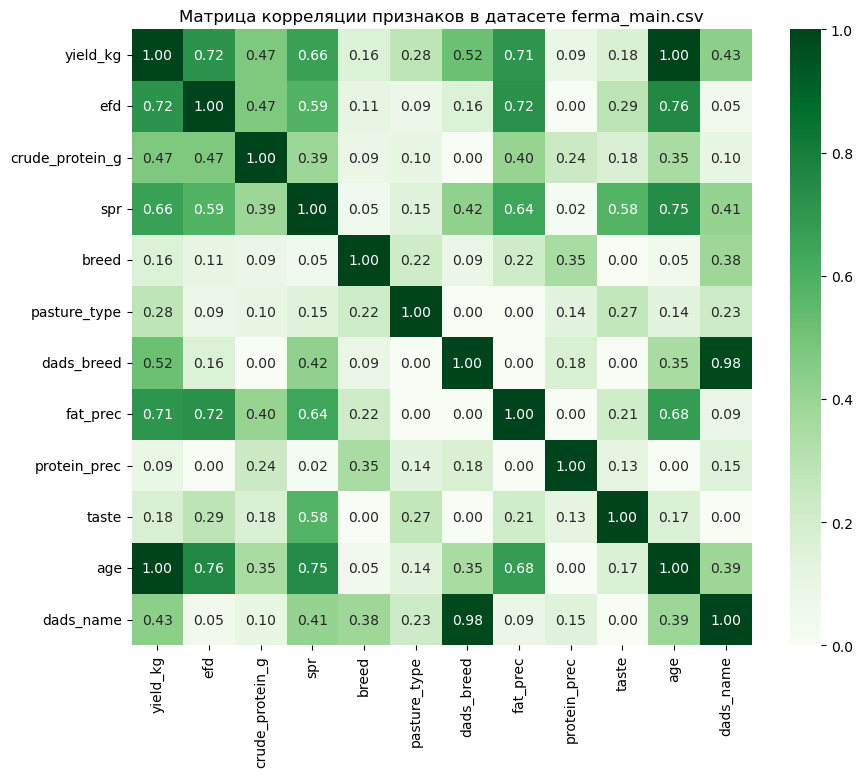

In [65]:
ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ferma_filtered_data.drop('id', axis=1).phik_matrix(['yield_kg', 'efd', 'crude_protein_g', 'spr', 'fat_prec', 'protein_prec']), 
            annot=True,
            cmap="Greens",
            fmt='.2f')

plt.title('Матрица корреляции признаков в датасете ferma_main.csv')
plt.show()

По матрице видно, что целевой признак коррелирует со следующими признаками:
- СПО
- ЭКЕ
- Тип пастбища
- Жирность,%
- Содержание сухого протеина, г
- Удой
- Возраст

Однако при создании модели линейной регрессии было выявлено, что признаки "Удой, кг", "ЭКЕ" и "Жирность,%" коррелируют с признаком "СПО", поэтому в модель их включать не будем. Сделаем копию фрейма и изменим данные признака "СПО"

In [66]:
# Копирование фрейма
ferma_copy = ferma_filtered_data.copy()
# Преобразование признака
ferma_copy['spr'] = ferma_copy['spr'] > 0.92

In [67]:
def get_log_model_ready(quan_columns, qual_columns, threshold=0.5):
    RANDOM_STATE = 42
    
    # разбиваем признаки на входные и целевой
    X = ferma_copy[quan_columns + qual_columns]
    y = ferma_copy['taste']

    # разбиваем данные на тренировочные и тестовые
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y,
        random_state=RANDOM_STATE
    )

    # Кодируем качественные признаки
    encoder = OneHotEncoder(drop='first', sparse=False)
    X_train_ohe = encoder.fit_transform(X_train[qual_columns])
    X_test_ohe = encoder.transform(X_test[qual_columns])

    encoder_col_names = encoder.get_feature_names_out()
    
    # Масштабируем количественные признаки
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[quan_columns])
    X_test_scaled = scaler.transform(X_test[quan_columns])

    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=quan_columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=quan_columns)
    
    # Обновляем тренировочные и тестовые выборки
    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

    clf = LogisticRegression()
    clf = clf.fit(X_train, y_train)
    
    y_proba = pd.Series(clf.predict_proba(X_test)[:,0])
    y_pred = y_proba.apply(lambda x: 'вкусно' if x >= threshold else 'не вкусно')
    
    print('Точность модели (accuracy) составляет:', accuracy_score(y_test, y_pred))
    print('Метрика recall составляет:', recall_score(y_test, y_pred, pos_label='вкусно'))
    print('Метрика precision составляет:', precision_score(y_test, y_pred, pos_label='вкусно'))
    
    # Выводим матрицу ошибок
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(confusion_matrix(y_test, y_pred, labels=['не вкусно', 'вкусно']),
                annot=True,
                fmt='d',
                cmap='Greens')

    plt.title('Матрица ошибок логистической модели')  
    
    plt.xlabel('Прогнозные данные')
    plt.ylabel('Фактические данные')
    
    ax.xaxis.set_ticklabels(['не вкусно', 'вкусно']);
    ax.yaxis.set_ticklabels(['не вкусно', 'вкусно']);
    
    plt.show()
    
    return {
        'scaler': scaler,
        'encoder': encoder,
        'model': clf,
        'model_proba_df': pd.DataFrame(zip(y_test, y_proba),
                                       columns = ['y_test', 'y_proba']).sort_values(by='y_proba',ascending=False)
    }

Точность модели (accuracy) составляет: 0.643312101910828
Метрика recall составляет: 0.8125
Метрика precision составляет: 0.6724137931034483


c:\Users\Public\New folder\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


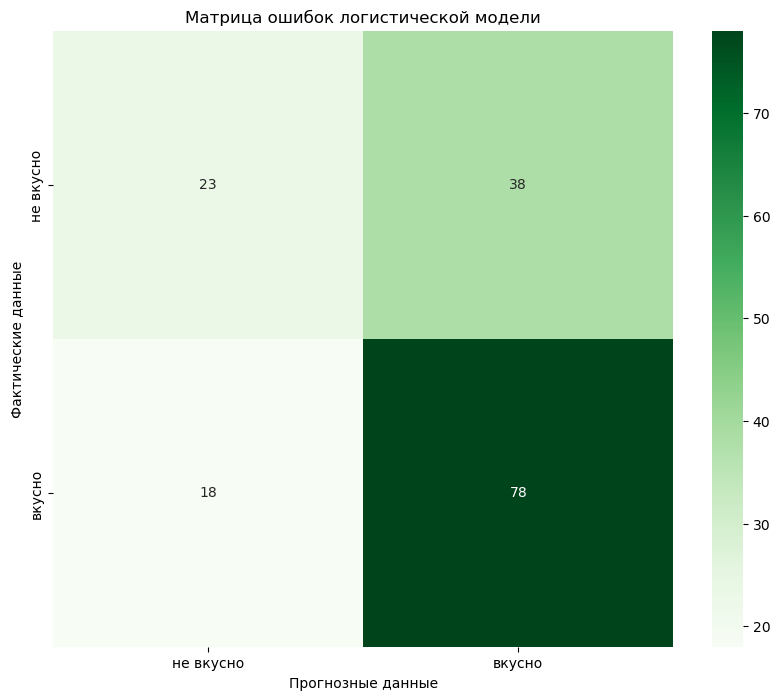

In [68]:
# Количественные данные
quan_cols = ['fat_prec', 'protein_prec']
# Качественные данные
qual_cols = ['pasture_type', 'age', 'breed', 'dads_name', 'dads_breed']
# Получение модели
log_model = get_log_model_ready(quan_cols, qual_cols)

Таким образом, данная модель дает верный ответ в 64% случаев. Модель чаще дает ложноположительный ответ (метрика precision меньше метрики recall, также это видно на матрице ошибок).<br>
Для заказчика важно получить вкусное молоко - значит, модель должна чаще давать **ошибки 2 рода** (повысить метрику precision).<br>Соответственно, надо **повышать** пороговое значение.

Найдем необходимое пороговое значение (от 0.5 до 1)

При пороговом значении 0.739 значение precision будет равно 1

Точность модели (accuracy) составляет: 0.4267515923566879
Метрика recall составляет: 0.0625
Метрика precision составляет: 1.0


c:\Users\Public\New folder\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


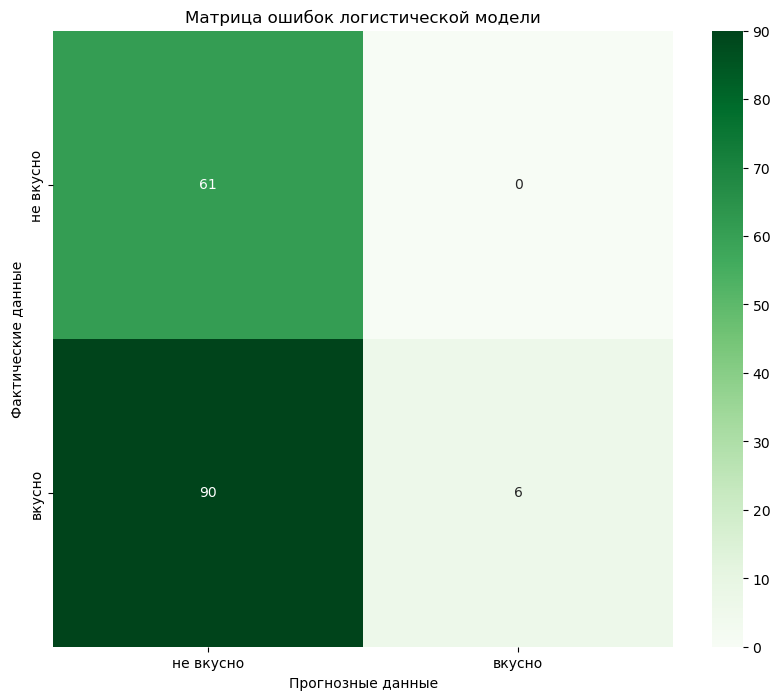

In [69]:
# Переменная для искомого порогового значения
target_threshold = 0
# Получаем значения прошлой версии модели
data = log_model['model_proba_df']
# Циклом ищем пороговое значение, при котором прогнозные значения "вкусно" ТОЛЬКО совпадают с фактическими
for i in [round(j, 5) for j in np.linspace(0.5, 1,num = 1000, endpoint=False)]:
    # Выделяем прогнозируемые значения при пороговом значении i на шаге
    data['y_pred'] = data['y_proba'].apply(lambda y_proba: 'вкусно' if y_proba >= i else 'не вкусно')
    # Проверка precision_score
    if precision_score(data['y_test'], data['y_pred'], pos_label='вкусно') == 1:
        # Если precision стало максимальным, то выходим из цикла, сохраняя нужное пороговое значение
        target_threshold = i
        break
# Выводим предельное пороговое значение
print(f'При пороговом значении {target_threshold} значение precision будет равно 1\n')
# Создаем новую модель и проверяем ее метрики
new_log_model = get_log_model_ready(quan_cols, qual_cols, threshold=target_threshold)

По анализу модели видно, что модель стала чаще ошибаться (снизился коэффициент точности). Однако мы добились того, что все коровы с прогнозным значением вкуса "вкусно" будут действительно с вкусным молоком.

**Для улучшения модели стоит повысить ее точность за счет добавления новых признаков**

Спрогнозируем вкус молока у покупаемых коров

In [75]:
# Копирование
buy_copy_data = buy_filtered_data.copy()

# Масштабирование и кодирвоание признаков
buy_copy_data = pd.concat([
    pd.DataFrame(                                                      # Создаем фрейм из
        new_log_model['scaler'].transform(buy_copy_data[quan_cols]),   # масштабированных признаков
        columns=quan_cols                                              # (колонками являются ключи кол. признаков лог. модели)
    ),
    pd.DataFrame(                                                      # Создаем фрейм из
        new_log_model['encoder'].transform(buy_copy_data[qual_cols]),  # закодированных признаков
        columns=new_log_model['encoder'].get_feature_names_out()       # вытаскиваем новые наименования признаков
    )],                                                                # и делаем их колонками фрейма 
    axis=1)[new_log_model['model'].feature_names_in_]

# Создаем новый столбец "Вкус" из прогнозируемых данных
buy_filtered_data['taste'] = (
                            pd.Series(new_log_model['model'].predict_proba(buy_copy_data)[:,0])   # Получаем series вероятностей
                            #.apply(lambda x: 'вкусно' if x >= target_threshold else 'не вкусно')  # Преобразуем в значения "вкусно"/"не вкусно"
                             )
# Проверка пяти случайных прогнозных значений
buy_filtered_data['taste']

0     0.643198
1     0.515498
2     0.513170
3     0.292127
4     0.503048
5     0.070637
6     0.593307
7     0.583808
8     0.197002
9     0.469233
10    0.101709
11    0.509417
12    0.376140
13    0.704647
14    0.077916
15    0.322091
Name: taste, dtype: float64

In [72]:
tasty_milk = (buy_filtered_data['taste'] == 'вкусно').sum()
not_tasty_milk = buy_filtered_data['taste'].count() - tasty_milk

print(f'В датасете "cow_buy.csv" присутствует {tasty_milk} коров с 100% вероятностью вкусным молоком и {not_tasty_milk} коров, \
по которым нельзя точно сказать, что оно невкусное')

В датасете "cow_buy.csv" присутствует 0 коров с 100% вероятностью вкусным молоком и 16 коров, по которым нельзя точно сказать, что оно невкусное


## Итоговые выводы

Мы уже добавили новые признаки в фрейм покупаемых коров. Теперь следует отобрать их на покупку. Выберем коров с вкусным молоком и удоем более 6000 кг

In [73]:
buy_final_data = buy_filtered_data.query('taste == "вкусно" and yield_kg > 6000')
print(f'Фермер может купить {buy_final_data.shape[0]} коров без риска на невкусное молоко и с хорошем удоем')

Фермер может купить 0 коров без риска на невкусное молоко и с хорошем удоем


Можем заключить, что нет коров, которые точно дадут вкусное молоко с требуемым удоем. Удой коров будет соответствовать действительности, если признаки "ЭКЕ (Энергетическая кормовая единица)", "Сырой протеин, г" и "СПО (Сахаро-протеиновое соотношение)" у данных коров выше на 5%, чем соответствующие средние показатели коров хозяйства. Для большей точности стоит уточнить значения данных признаков у продавцов.

**Итог моделей линейной регрессии:**
- Наиболее точной из трех моделей оказалась третья модель
- Все модели завышают результат
- Точность лучшей модели составила 0.816, доверительный интервал при уровене уверенности в 95% составляет от 6125.44 кг до 6614.56 кг
- Для проверки корректности моделей были использованы следующие [метрики](#metrics): MSE, MAE, RMSE, R² и сумма остатков
- Для улучшения моделей были преобразованы коррелируемые входные признаки, также преобразованы типы взаимосвязи с целевым признаком
- Для улучшения модели стоит найти возможные иные (нелинейные) взаимосвязи входных признаков с целевым, а также дополнить новыми входными признаками

**Итог моделей логической регрессии:**
- Точность итоговой модели - 42.68%
- Модель всегда выдает корректные значения "вкусно" признака "вкус"
- Повышение точности модели будет достигнуто за счет добавления новых признаков или настройки гиперпараметров модели